# Model Development

In [282]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import mlflow
import mlflow.keras
import mlflow.sklearn
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.metrics import (confusion_matrix, classification_report, 
                             f1_score, precision_score, recall_score, 
                             accuracy_score, multilabel_confusion_matrix)
from mlflow.models.signature import ModelSignature,  infer_signature
from mlflow.types.schema import Schema, TensorSpec
import time
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [283]:
file_path = '/Users/sarayetel/Desktop/UT/Data Science/DataScience/Project/Phase2/data/finall_df.csv'
df = pd.read_csv(file_path)


In [284]:
df.head()

movie_id                  movie_name    rating  certification  \
0         0    The Shawshank Redemption  2.785414              3   
1         1               The Godfather  2.785414              3   
2         2  Selena Gomez: My Mind & Me  2.785414              2   
3         3       The Godfather Part II  2.647335              3   
4         4            Schindler's List  2.647335              3   

   budget_revenue_ratio                                           overview  \
0          1.598095e-01  [-3.19397002e-02 -4.66426834e-02 -4.91477661e-...   
1         -1.004498e+00  [-7.44419992e-02  6.91856220e-02 -5.69341108e-...   
2         -1.819280e-17  [ 4.69592633e-03 -8.61732885e-02  5.47824800e-...   
3         -8.657201e-01  [-3.66872773e-02  3.39940190e-02 -7.25953653e-...   
4         -9.447978e-01  [-5.26852831e-02  7.54732043e-02 -7.52171502e-...   

                                              review  actor_Adam_Sandler  \
0  [-2.28308234e-03 -3.07130292e-02 -5.99616654e-...                   0   
1  [-1.24374419e-01  1.80206597e-02 -1.23060025e-...                   0   
2  [-2.45358776e-02 -9.08434242e-02  1.08346958e-...                   0   
3  [-6.97815567e-02  5.17734792e-03 -7.59101212e-...                   0   
4  [-4.90368381e-02 -3.01354378e-02 -3.65204886e-...                   0   

   actor_Al_Pacino  actor_Alec_Baldwin  ...  genre_Horror  genre_Music  \
0                0                   0  ...             0            0   
1                1                   0  ...             0            0   
2                0                   0  ...             0            1   
3                1                   0  ...             0            0   
4                0                   0  ...             0            0   

   genre_Mystery  genre_Romance  genre_Science Fiction  genre_TV Movie  \
0              0              0                      0               0   
1              0              0                      0               0   
2              0              0                      0               0   
3              0              0                      0               0   
4              0              0                      0               0   

   genre_Thriller  genre_War  genre_Western  genre_unknown  
0               0          0              0              0  
1               0          0              0              0  
2               0          0              0              0  
3               0          0              0              0  
4               0          1              0              0  

[5 rows x 723 columns]

In [285]:
genre_columns = ['genre_Comedy', 'genre_Crime', 'genre_Documentary',
                'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History',
                'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance',
                'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller',
                'genre_War', 'genre_Western']
y = df[genre_columns]
y

genre_Comedy  genre_Crime  genre_Documentary  genre_Drama  genre_Family  \
0                0            1                  0            1             0   
1                0            1                  0            1             0   
2                0            0                  1            0             0   
3                0            1                  0            1             0   
4                0            0                  0            1             0   
...            ...          ...                ...          ...           ...   
9989             0            0                  0            0             0   
9990             1            0                  0            0             0   
9991             0            0                  0            0             0   
9992             0            0                  0            0             0   
9993             0            0                  0            0             0   

      genre_Fantasy  genre_History  genre_Horror  genre_Music  genre_Mystery  \
0                 0              0             0            0              0   
1                 0              0             0            0              0   
2                 0              0             0            1              0   
3                 0              0             0            0              0   
4                 0              1             0            0              0   
...             ...            ...           ...          ...            ...   
9989              0              0             1            0              1   
9990              0              0             0            0              0   
9991              0              0             1            0              0   
9992              0              0             1            0              1   
9993              0              0             0            0              0   

      genre_Romance  genre_Science Fiction  genre_TV Movie  genre_Thriller  \
0                 0                      0               0               0   
1                 0                      0               0               0   
2                 0                      0               0               0   
3                 0                      0               0               0   
4                 0                      0               0               0   
...             ...                    ...             ...             ...   
9989              0                      1               0               0   
9990              0                      0               0               0   
9991              0                      1               0               0   
9992              0                      0               0               1   
9993              0                      0               0               1   

      genre_War  genre_Western  
0             0              0  
1             0              0  
2             0              0  
3             0              0  
4             1              0  
...         ...            ...  
9989          0              0  
9990          0              0  
9991          0              0  
9992          0              0  
9993          0              0  

[9994 rows x 16 columns]

In [286]:
df = df.drop(columns=["movie_id", "movie_name"])


In [287]:
df['overview_parsed'] = df['overview'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

overview_array = np.vstack(df['overview_parsed'].values)
overview_df = pd.DataFrame(overview_array, columns=[f"overview_emb_{i}" for i in range(overview_array.shape[1])])

df = pd.concat([df.drop(columns=['overview', 'overview_parsed']), overview_df], axis=1)


In [ ]:
df['review_parsed'] = df['review'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

review_array = np.vstack(df['review_parsed'].values)
review_df = pd.DataFrame(review_array, columns=[f"review_emb_{i}" for i in range(review_array.shape[1])])

df = pd.concat([df.drop(columns=['review', 'review_parsed']), review_df], axis=1)

In [297]:
combination_counts = y.apply(tuple, axis=1).value_counts()

print("All unique genre combinations:")
print(len(combination_counts))

rare_combinations = combination_counts[combination_counts < 10]
print(f"\nNumber of rare combinations (<10 examples): {len(rare_combinations)}")

would_remove = (combination_counts < 10).sum()
print(f"\nTotal examples in rare combinations: {rare_combinations.sum()}")

All unique genre combinations:
487

Number of rare combinations (<10 examples): 363

Total examples in rare combinations: 834


## Optional : Keep data with target label with more than 10 example

In [289]:
# combination_counts = y.apply(tuple, axis=1).value_counts()

# keep_mask = y.apply(tuple, axis=1).map(combination_counts) >= 10

# df = df[keep_mask].copy()
# y = y[keep_mask].copy()

# df = df.reset_index(drop=True)
# y = y.reset_index(drop=True)

# # # Verify
# print(f"Original shape: {df.shape}")
# print(f"Filtered shape: {y.shape}")

In [290]:
df

rating  certification  budget_revenue_ratio  actor_Adam_Sandler  \
0     2.785414              3          1.598095e-01                   0   
1     2.785414              3         -1.004498e+00                   0   
2     2.785414              2         -1.819280e-17                   0   
3     2.647335              3         -8.657201e-01                   0   
4     2.647335              3         -9.447978e-01                   0   
...        ...            ...                   ...                 ...   
9989 -2.461580              3          2.107988e+00                   0   
9990 -2.461580              2          1.589702e-01                   0   
9991 -2.461580              3         -1.819280e-17                   0   
9992 -2.461580              1         -1.819280e-17                   0   
9993 -2.461580              3          2.107988e+00                   0   

      actor_Al_Pacino  actor_Alec_Baldwin  actor_Anthony_Hopkins  \
0                   0                   0                      0   
1                   1                   0                      0   
2                   0                   0                      0   
3                   1                   0                      0   
4                   0                   0                      0   
...               ...                 ...                    ...   
9989                0                   0                      0   
9990                0                   0                      0   
9991                0                   0                      0   
9992                0                   0                      0   
9993                0                   0                      0   

      actor_Anthony_Mackie  actor_Antonio_Banderas  actor_Ben_Affleck  ...  \
0                        0                       0                  0  ...   
1                        0                       0                  0  ...   
2                        0                       0                  0  ...   
3                        0                       0                  0  ...   
4                        0                       0                  0  ...   
...                    ...                     ...                ...  ...   
9989                     0                       0                  0  ...   
9990                     0                       0                  0  ...   
9991                     0                       0                  0  ...   
9992                     0                       0                  0  ...   
9993                     0                       0                  0  ...   

      review_emb_374  review_emb_375  review_emb_376  review_emb_377  \
0           0.053560       -0.002838       -0.047090       -0.002129   
1           0.000107       -0.082925        0.035515        0.128220   
2           0.080234        0.070669       -0.055583        0.077361   
3           0.058351       -0.035163       -0.031308        0.111779   
4           0.075662        0.027540        0.008901        0.050304   
...              ...             ...             ...             ...   
9989        0.107304        0.011428        0.013367       -0.012747   
9990        0.055544        0.027847       -0.078422        0.048907   
9991        0.121075       -0.055098       -0.031327        0.070009   
9992        0.055948       -0.019725       -0.065152        0.097965   
9993        0.107304        0.011428        0.013367       -0.012747   

      review_emb_378  review_emb_379  review_emb_380  review_emb_381  \
0           0.025929        0.009465        0.038715        0.020291   
1           0.054195       -0.042681        0.017098        0.014809   
2          -0.061389        0.043334        0.096590        0.076758   
3           0.014740       -0.007432        0.099451       -0.003907   
4          -0.058099       -0.019563        0.095674        0.009429   
...              ...             ...             ...    

In [291]:
genre_columns_to_drop = ['genre_Comedy', 'genre_Crime', 'genre_Documentary',
                'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History',
                'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance',
                'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller',
                'genre_War', 'genre_Western']
X = df.drop(columns=genre_columns_to_drop)
X.head()

rating  certification  budget_revenue_ratio  actor_Adam_Sandler  \
0  2.785414              3          1.598095e-01                   0   
1  2.785414              3         -1.004498e+00                   0   
2  2.785414              2         -1.819280e-17                   0   
3  2.647335              3         -8.657201e-01                   0   
4  2.647335              3         -9.447978e-01                   0   

   actor_Al_Pacino  actor_Alec_Baldwin  actor_Anthony_Hopkins  \
0                0                   0                      0   
1                1                   0                      0   
2                0                   0                      0   
3                1                   0                      0   
4                0                   0                      0   

   actor_Anthony_Mackie  actor_Antonio_Banderas  actor_Ben_Affleck  ...  \
0                     0                       0                  0  ...   
1                     0                       0                  0  ...   
2                     0                       0                  0  ...   
3                     0                       0                  0  ...   
4                     0                       0                  0  ...   

   review_emb_374  review_emb_375  review_emb_376  review_emb_377  \
0        0.053560       -0.002838       -0.047090       -0.002129   
1        0.000107       -0.082925        0.035515        0.128220   
2        0.080234        0.070669       -0.055583        0.077361   
3        0.058351       -0.035163       -0.031308        0.111779   
4        0.075662        0.027540        0.008901        0.050304   

   review_emb_378  review_emb_379  review_emb_380  review_emb_381  \
0        0.025929        0.009465        0.038715        0.020291   
1        0.054195       -0.042681        0.017098        0.014809   
2       -0.061389        0.043334        0.096590        0.076758   
3        0.014740       -0.007432        0.099451       -0.003907   
4       -0.058099       -0.019563        0.095674        0.009429   

   review_emb_382  review_emb_383  
0        0.027773       -0.030786  
1        0.068468       -0.027395  
2       -0.017577       -0.032614  
3        0.034921       -0.011986  
4       -0.033070        0.003425  

[5 rows x 1471 columns]

### Train-Val-Test Split (80/10/10)

In [292]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)


In [267]:
y_test_more10 = y_test.copy()

In [279]:
y_test_all = y_test.copy()

# Best Models with MLFlow

In [ ]:
tracking_uri = "file:///Users/sarayetel/Desktop/UT/DataScience/DataScience/Project/Phase3/mlruns"

## 1. FCNN

In [ ]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("NN_Experiments")

input_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, X_train.shape[1]), "input")
])
output_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, 17), "output")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

params_to_test = [
    # Baseline configuration
    {
        "learning_rate": 1e-4,
        "batch_size": 64,
        "dropout_rate": 0.3,
        "hidden_units": [512, 512, 256],
        "activation": "relu",
        "batch_norm": True,
        "optimizer": "adam",
        "l2_reg": 0.0,
        "use_early_stopping": False
    },
    
    # Deeper network with more regularization
    {
        "learning_rate": 3e-4,
        "batch_size": 128,
        "dropout_rate": 0.5,
        "hidden_units": [1024, 512, 256, 128],
        "activation": "leaky_relu",
        "batch_norm": True,
        "optimizer": "adam",
        "l2_reg": 0.001,
        "use_early_stopping": True
    },
    
    # Different optimizer (Nadam) with ELU
    {
        "learning_rate": 1e-3,
        "batch_size": 32,
        "dropout_rate": 0.2,
        "hidden_units": [512, 256, 128],
        "activation": "elu",
        "batch_norm": False,
        "optimizer": "nadam",
        "l2_reg": 0.0,
        "use_early_stopping": False
    },
    
    # Higher regularization setup
    {
        "learning_rate": 5e-5,
        "batch_size": 256,
        "dropout_rate": 0.4,
        "hidden_units": [512, 256],
        "activation": "relu",
        "batch_norm": True,
        "optimizer": "rmsprop",
        "l2_reg": 0.01,
        "use_early_stopping": True
    },
    
    # Minimalist configuration
    {
        "learning_rate": 1e-4,
        "batch_size": 32,
        "dropout_rate": 0.1,
        "hidden_units": [256, 128],
        "activation": "relu",
        "batch_norm": False,
        "optimizer": "adam",
        "l2_reg": 0.0,
        "use_early_stopping": False
    }
]

for params in params_to_test:
    with mlflow.start_run(run_name=f"NN_lr{params['learning_rate']}_bs{params['batch_size']}"):
        start_time = time.time()
        
        mlflow.log_params(params)
        mlflow.log_param("dataset", "all_data")

        model = Sequential()

        model.add(Dense(
            params["hidden_units"][0],
            activation=params["activation"],
            input_shape=(X_train.shape[1],),
            kernel_regularizer=l2(params["l2_reg"])
        ))
        
        if params["batch_norm"]:
            model.add(BatchNormalization())
        model.add(Dropout(params["dropout_rate"]))

        for units in params["hidden_units"][1:]:
            model.add(Dense(
                units,
                activation=params["activation"],
                kernel_regularizer=l2(params["l2_reg"])
            ))
            if params["batch_norm"]:
                model.add(BatchNormalization())
            model.add(Dropout(params["dropout_rate"]))

        model.add(Dense(17, activation='sigmoid'))

        optimizer_config = {
            "learning_rate": params["learning_rate"]
        }
        optimizers = {
            "adam": Adam(**optimizer_config),
            "nadam": Nadam(**optimizer_config),
            "rmsprop": RMSprop(**optimizer_config)
        }
        
        model.compile(
            loss='binary_crossentropy',
            optimizer=optimizers[params["optimizer"]],
            metrics=['accuracy']
        )

        callbacks = []
        if params["use_early_stopping"]:
            from tensorflow.keras.callbacks import EarlyStopping
            callbacks.append(EarlyStopping(monitor='val_loss', patience=5))

        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=params["batch_size"],
            validation_data=(X_val, y_val),
            verbose=1,
            callbacks=callbacks
        )

        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        f1_micro = f1_score(y_test, y_pred_binary, average='micro')
        metrics = {
            "score": f1_micro,
            "f1_micro": f1_micro,
            "f1_macro": f1_score(y_test, y_pred_binary, average='macro'),
            "precision": precision_score(y_test, y_pred_binary, average='micro'),
            "recall": recall_score(y_test, y_pred_binary, average='micro'),
            "final_epoch": len(history.history['loss']),
            "final_train_loss": history.history['loss'][-1],
            "final_val_loss": history.history['val_loss'][-1]
        }
        
        for name, value in metrics.items():
            mlflow.log_metric(name, value)

        duration = time.time() - start_time
        mlflow.log_metric("duration_seconds", duration)
        
        mlflow.keras.log_model(
            model,
            artifact_path="model",
            signature=signature,
            registered_model_name="neural_network",
            metadata={
                "metrics": metrics,
                "params": params,
                "num_parameters": model.count_params()
            }
        )
        
        print(f"Completed run with score: {f1_micro:.4f}")
        print(f"Parameters: {params}")

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0940 - loss: 0.9088 - val_accuracy: 0.2697 - val_loss: 0.6801
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2179 - loss: 0.7935 - val_accuracy: 0.3450 - val_loss: 0.6543
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2851 - loss: 0.7283 - val_accuracy: 0.4258 - val_loss: 0.5965
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3395 - loss: 0.6763 - val_accuracy: 0.4934 - val_loss: 0.5431
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3683 - loss: 0.6263 - val_accuracy: 0.5218 - val_loss: 0.4930
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4121 - loss: 0.5731 - val_accuracy: 0.5317 - val_loss: 0.4491
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4473 - loss: 0.5208 - val_accuracy: 0.5426 - val_loss: 0.4006
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4584 - loss: 0.4608 - val_accu

Registered model 'neural_network' already exists. Creating a new version of this model...
Created version '6' of model 'neural_network'.


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0773 - loss: 3.3036 - val_accuracy: 0.1801 - val_loss: 2.7731
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1551 - loss: 2.9256 - val_accuracy: 0.4258 - val_loss: 2.5243
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2121 - loss: 2.6372 - val_accuracy: 0.4203 - val_loss: 2.2904
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2706 - loss: 2.3664 - val_accuracy: 0.4039 - val_loss: 2.0699
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3174 - loss: 2.1166 - val_accuracy: 0.4421 - val_loss: 1.8553
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3640 - loss: 1.8822 - val_accuracy: 0.4618 - val_loss: 1.6522
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4142 - loss: 1.6602 - val_accuracy: 0.4782 - val_loss: 1.4607
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4492 - loss: 1.4597 - val_accuracy: 0.5131 - val_l

Registered model 'neural_network' already exists. Creating a new version of this model...
Created version '7' of model 'neural_network'.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3953 - loss: 0.2812 - val_accuracy: 0.5535 - val_loss: 0.1587
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5521 - loss: 0.1555 - val_accuracy: 0.5186 - val_loss: 0.1517
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5661 - loss: 0.1385 - val_accuracy: 0.5295 - val_loss: 0.1505
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5632 - loss: 0.1288 - val_accuracy: 0.5306 - val_loss: 0.1568
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5565 - loss: 0.1198 - val_accuracy: 0.5251 - val_loss: 0.1626
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5694 - loss: 0.1145 - val_accuracy: 0.5371 - val_loss: 0.1692
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5720 - loss: 0.1085 - val_accuracy: 0.5251 - val_loss: 0.1691
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5620 - loss: 0.1031 - val_accuracy: 0.4913

Registered model 'neural_network' already exists. Creating a new version of this model...
Created version '8' of model 'neural_network'.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0774 - loss: 11.7555 - val_accuracy: 0.0295 - val_loss: 11.0013
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1117 - loss: 11.1095 - val_accuracy: 0.0087 - val_loss: 10.4674
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1277 - loss: 10.5585 - val_accuracy: 0.0076 - val_loss: 9.9565
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1306 - loss: 10.0391 - val_accuracy: 0.0087 - val_loss: 9.4647
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1615 - loss: 9.5360 - val_accuracy: 0.0164 - val_loss: 8.9899
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1713 - loss: 9.0504 - val_accuracy: 0.0273 - val_loss: 8.5320
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1899 - loss: 8.5891 - val_accuracy: 0.0415 - val_loss: 8.0909
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2105 - loss: 8.1409 - val_accuracy: 0.0721 -

Registered model 'neural_network' already exists. Creating a new version of this model...
Created version '9' of model 'neural_network'.


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1657 - loss: 0.5769 - val_accuracy: 0.3646 - val_loss: 0.2840
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3812 - loss: 0.2825 - val_accuracy: 0.4312 - val_loss: 0.2418
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4382 - loss: 0.2427 - val_accuracy: 0.4989 - val_loss: 0.2099
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4880 - loss: 0.2128 - val_accuracy: 0.5317 - val_loss: 0.1915
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5142 - loss: 0.1961 - val_accuracy: 0.5557 - val_loss: 0.1788
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5444 - loss: 0.1802 - val_accuracy: 0.5459 - val_loss: 0.1711
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5552 - loss: 0.1753 - val_accuracy: 0.5448 - val_loss: 0.1647
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5554 - loss: 0.1669 - val_accuracy: 0.5775

Registered model 'neural_network' already exists. Creating a new version of this model...
Created version '10' of model 'neural_network'.


## 2. XGBoost

In [ ]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("XGBoost_Experiments")

strategic_combinations = [
    # Baseline
    {
        "learning_rate": [0.1],
        "max_depth": [6],
        "n_estimators": [100],
        "subsample": [1.0],
        "colsample_bytree": [1.0],
        "min_child_weight": [1],
        "gamma": [0]
    },
    # Regularized
    {
        "learning_rate": [0.05],
        "max_depth": [8],
        "n_estimators": [200],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
        "min_child_weight": [3],
        "gamma": [0.1]
    },
    # High learning rate
    {
        "learning_rate": [0.3],
        "max_depth": [4],
        "n_estimators": [80],
        "subsample": [1.0],
        "colsample_bytree": [1.0],
        "min_child_weight": [1],
        "gamma": [0]
    },
    # Conservative
    {
        "learning_rate": [0.01],
        "max_depth": [5],
        "n_estimators": [300],
        "subsample": [0.9],
        "colsample_bytree": [0.9],
        "min_child_weight": [5],
        "gamma": [0.2]
    }
]

for combo in strategic_combinations:
    grid = ParameterGrid(combo)
    for params in grid:
        with mlflow.start_run(run_name=f"XGB_lr{params['learning_rate']}_d{params['max_depth']}"):
            start_time = time.time()

            mlflow.log_params({
                "model_type": "MultiOutputClassifier",
                "base_model": "XGBClassifier",
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "use_label_encoder": False,
                **params
            })

            mlflow.log_param("dataset", "all_data")

            xgb_model = xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                verbosity=0,
                **params
            )
            
            multi_xgb = MultiOutputClassifier(xgb_model)
            multi_xgb.fit(X_train, y_train)

            y_pred = multi_xgb.predict(X_test)
            y_proba = multi_xgb.predict_proba(X_test)

            f1_micro = f1_score(y_test, y_pred, average='micro')
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_weighted = f1_score(y_test, y_pred, average='weighted')
            
            metrics = {
                "score": f1_micro,
                "f1_micro": f1_micro,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "training_time": time.time() - start_time
            }

            for name, value in metrics.items():
                mlflow.log_metric(name, value)
                
            signature = infer_signature(X_train, y_proba)
            mlflow.sklearn.log_model(
                multi_xgb,
                "model",
                signature=signature,
                registered_model_name="XGBoost",
                metadata={
                    "metrics": metrics,
                    "params": params
                }
            )
            
            print(f"Completed run with F1 micro: {f1_micro:.4f}")
            print(f"Parameters: {params}")

Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '5' of model 'XGBoost'.


Completed run with F1 micro: 0.6452
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '6' of model 'XGBoost'.


Completed run with F1 micro: 0.6522
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '7' of model 'XGBoost'.


Completed run with F1 micro: 0.6524
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 80, 'subsample': 1.0}
Completed run with F1 micro: 0.5864
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '8' of model 'XGBoost'.


## 3. LGBM

In [ ]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("LightGBM_Experiments")

strategic_combinations = [
    # Baseline
    {
        "learning_rate": [0.1],
        "n_estimators": [100],
        "boosting_type": ["gbdt"],
        "num_leaves": [31],
        "max_depth": [-1],
        "min_child_samples": [20],
        "subsample": [1.0]
    },
    
    # Deeper trees with regularization
    {
        "learning_rate": [0.05],
        "n_estimators": [200],
        "boosting_type": ["gbdt"],
        "num_leaves": [63],
        "max_depth": [7],
        "min_child_samples": [30],
        "subsample": [0.8],
        "reg_alpha": [0.1],
        "reg_lambda": [0.1]
    },
    
    # Faster training configuration
    {
        "learning_rate": [0.2],
        "n_estimators": [50],
        "boosting_type": ["goss"],
        "num_leaves": [31],
        "max_depth": [5],
        "min_child_samples": [10],
        "subsample": [1.0]
    },
    
    # Conservative configuration
    {
        "learning_rate": [0.01],
        "n_estimators": [300],
        "boosting_type": ["gbdt"],
        "num_leaves": [127],
        "max_depth": [-1],
        "min_child_samples": [50],
        "subsample": [0.9],
        "reg_alpha": [0.5],
        "reg_lambda": [0.5]
    },
    
    # Dart booster (dropout) configuration
    {
        "learning_rate": [0.1],
        "n_estimators": [100],
        "boosting_type": ["dart"],
        "num_leaves": [31],
        "max_depth": [-1],
        "min_child_samples": [20],
        "subsample": [1.0],
        "drop_rate": [0.1]
    }
]

for combo in strategic_combinations:
    grid = ParameterGrid(combo)
    for params in grid:
        run_name = f"LGBM_lr{params['learning_rate']}_est{params['n_estimators']}_bt{params['boosting_type']}"
        
        with mlflow.start_run(run_name=run_name):
            start_time = time.time()

            mlflow.log_params({
                "model_type": "MultiOutputClassifier",
                "base_model": "LGBMClassifier",
                **params
            })
            
            mlflow.log_param("dataset", "all_data")            
            lgbm_model = LGBMClassifier(
                objective='binary',
                verbose=-1, 
                **params
            )
            
            multi_lgbm = MultiOutputClassifier(lgbm_model)
            multi_lgbm.fit(X_train, y_train)

            y_pred = multi_lgbm.predict(X_test)
            y_proba = multi_lgbm.predict_proba(X_test)

            f1_micro = f1_score(y_test, y_pred, average='micro')
            f1_macro = f1_score(y_test, y_pred, average='macro')
            precision = precision_score(y_test, y_pred, average='micro')
            recall = recall_score(y_test, y_pred, average='micro')
            
            metrics = {
                "score": f1_micro, 
                "f1_micro": f1_micro,
                "f1_macro": f1_macro,
                "precision": precision,
                "recall": recall,
                "training_time": time.time() - start_time
            }

            for name, value in metrics.items():
                mlflow.log_metric(name, value)

            signature = infer_signature(X_train, y_proba)
            mlflow.sklearn.log_model(
                multi_lgbm,
                "model",
                signature=signature,
                registered_model_name="LightGBM",
                metadata={
                    "metrics": metrics,
                    "params": params
                }
            )
            
            print(f"Completed run {run_name}")
            print(f"F1 Micro: {f1_micro:.4f} | Time: {metrics['training_time']:.2f}s")
            print(f"Parameters: {params}\n")

Registered model 'LightGBM' already exists. Creating a new version of this model...
Created version '6' of model 'LightGBM'.


Completed run LGBM_lr0.1_est100_btgbdt
F1 Micro: 0.6621 | Time: 51.30s
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}



Registered model 'LightGBM' already exists. Creating a new version of this model...
Created version '7' of model 'LightGBM'.


Completed run LGBM_lr0.05_est200_btgbdt
F1 Micro: 0.6544 | Time: 84.72s
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}



Registered model 'LightGBM' already exists. Creating a new version of this model...
Created version '8' of model 'LightGBM'.


Completed run LGBM_lr0.2_est50_btgoss
F1 Micro: 0.6207 | Time: 16.27s
Parameters: {'boosting_type': 'goss', 'learning_rate': 0.2, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 1.0}



Registered model 'LightGBM' already exists. Creating a new version of this model...
Created version '9' of model 'LightGBM'.


Completed run LGBM_lr0.01_est300_btgbdt
F1 Micro: 0.6097 | Time: 180.36s
Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 300, 'num_leaves': 127, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.9}

Completed run LGBM_lr0.1_est100_btdart
F1 Micro: 0.6301 | Time: 58.15s
Parameters: {'boosting_type': 'dart', 'drop_rate': 0.1, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}



Registered model 'LightGBM' already exists. Creating a new version of this model...
Created version '10' of model 'LightGBM'.


## 4. DNN + XGBoost

In [ ]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("DNN_XGBoost_Experiments")

dnn_input_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, X_train.shape[1]), "input_features")
])
dnn_output_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, 256), "extracted_features") 
])

xgb_input_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, 256), "dnn_features")
])
xgb_output_schema = Schema([
    TensorSpec(np.dtype('float32'), (-1, 17), "predictions")
])

dnn_params_grid = [
    {
        "dnn_layers": [[512, 512, 512, 256]],
        "dropout_rate": [0.3],
        "learning_rate": [1e-4],
        "batch_size": [64],
        "epochs": [60],
        "optimizer": ["adam"]
    },
    {
        "dnn_layers": [[1024, 512, 256]],
        "dropout_rate": [0.4],
        "learning_rate": [5e-5],
        "batch_size": [128],
        "epochs": [80],
        "optimizer": ["adam"]
    },
    {
        "dnn_layers": [[512, 256, 128]],
        "dropout_rate": [0.2],
        "learning_rate": [1e-3],
        "batch_size": [32],
        "epochs": [40],
        "optimizer": ["nadam"]
    }
]

xgb_params_grid = [
    {
        "learning_rate": [0.1],
        "max_depth": [6],
        "n_estimators": [100],
        "subsample": [1.0]
    },
    {
        "learning_rate": [0.05],
        "max_depth": [8],
        "n_estimators": [200],
        "subsample": [0.8]
    },
    {
        "learning_rate": [0.2],
        "max_depth": [4],
        "n_estimators": [50],
        "subsample": [1.0]
    }
]

for dnn_params in ParameterGrid(dnn_params_grid):
    for xgb_params in ParameterGrid(xgb_params_grid):
        run_name = (f"DNN_{'-'.join(map(str, dnn_params['dnn_layers']))}_"
                   f"XGB_lr{xgb_params['learning_rate']}_d{xgb_params['max_depth']}")
        
        with mlflow.start_run(run_name=run_name):
            start_time = time.time()

            mlflow.log_params({
                "feature_model": "DNN",
                "classifier_model": "XGBoost",
                **dnn_params,
                **{"xgb_" + k: v for k, v in xgb_params.items()}
            })

            mlflow.log_param("dataset", "all_data")
            input_layer = Input(shape=(X_train.shape[1],))
            x = input_layer
            
            for units in dnn_params["dnn_layers"]:
                x = Dense(units, activation='relu')(x)
                x = BatchNormalization()(x)
                x = Dropout(dnn_params["dropout_rate"])(x)
            
            feature_output = x
            output_layer = Dense(17, activation='sigmoid')(feature_output)

            optimizers = {
                "adam": Adam(learning_rate=dnn_params["learning_rate"]),
                "nadam": Nadam(learning_rate=dnn_params["learning_rate"])
            }
            
            dnn = Model(inputs=input_layer, outputs=output_layer)
            dnn.compile(
                loss='binary_crossentropy',
                optimizer=optimizers[dnn_params["optimizer"]],
                metrics=['accuracy']
            )

            history = dnn.fit(
                X_train, y_train,
                epochs=dnn_params["epochs"],
                batch_size=dnn_params["batch_size"],
                validation_data=(X_val, y_val),
                verbose=1
            )

            feature_extractor = Model(inputs=dnn.input, outputs=feature_output)
            X_train_dnn_feat = feature_extractor.predict(X_train)
            X_test_dnn_feat = feature_extractor.predict(X_test)

            xgb_model = xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                verbosity=0,
                **xgb_params
            )
            multi_xgb = MultiOutputClassifier(xgb_model)
            multi_xgb.fit(X_train_dnn_feat, y_train)

            y_pred = multi_xgb.predict(X_test_dnn_feat)
            y_proba = multi_xgb.predict_proba(X_test_dnn_feat)
            
            metrics = {
                "score": f1_score(y_test, y_pred, average='micro'),
                "f1_micro": f1_score(y_test, y_pred, average='micro'),
                "f1_macro": f1_score(y_test, y_pred, average='macro'),
                "precision": precision_score(y_test, y_pred, average='micro'),
                "recall": recall_score(y_test, y_pred, average='micro'),
                "training_time": time.time() - start_time,
                "final_dnn_loss": history.history['loss'][-1],
                "final_dnn_val_loss": history.history['val_loss'][-1]
            }

            for name, value in metrics.items():
                mlflow.log_metric(name, value)

            dnn_signature = ModelSignature(
                inputs=dnn_input_schema,
                outputs=dnn_output_schema
            )
            
            xgb_signature = ModelSignature(
                inputs=xgb_input_schema,
                outputs=xgb_output_schema
            )

            mlflow.sklearn.log_model(
                multi_xgb,
                "xgb_model",
                signature=xgb_signature,
                registered_model_name="Hybrid_XGBoost",
                metadata={
                    "dnn_params": dnn_params,
                    "xgb_params": xgb_params,
                    "metrics": metrics
                }
            )
            
            mlflow.keras.log_model(
                feature_extractor,
                "dnn_feature_extractor",
                signature=dnn_signature,
                registered_model_name="Hybrid_DNN_Feature_Extractor",
                metadata={
                    "params": dnn_params,
                    "metrics": metrics
                }
            )

            print(f"Run completed: {run_name}")
            print(f"F1 Micro: {metrics['score']:.4f}")
            print(f"Training time: {metrics['training_time']:.2f}s\n")

Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0729 - loss: 0.9283 - val_accuracy: 0.0175 - val_loss: 0.7059
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1648 - loss: 0.8183 - val_accuracy: 0.1790 - val_loss: 0.6692
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2184 - loss: 0.7497 - val_accuracy: 0.3624 - val_loss: 0.6252
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2653 - loss: 0.7003 - val_accuracy: 0.4552 - val_loss: 0.5676
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3054 - loss: 0.6467 - val_accuracy: 0.4858 - val_loss: 0.5290
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3523 - loss: 0.5990 - val_accuracy: 0.4880 - val_loss: 0.4855
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3842 - loss: 0.5364 - val_accuracy: 0.5044 - val_loss: 0.4303
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4241 - loss: 0.4856 - val_accuracy: 0

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '10' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-512-512-256_XGB_lr0.1_d6
F1 Micro: 0.7090
Training time: 76.44s

Epoch 1/60


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '10' of model 'Hybrid_DNN_Feature_Extractor'.


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0872 - loss: 0.9145 - val_accuracy: 0.0895 - val_loss: 0.6912
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1768 - loss: 0.8131 - val_accuracy: 0.2009 - val_loss: 0.6894
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2432 - loss: 0.7505 - val_accuracy: 0.3843 - val_loss: 0.6328
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2753 - loss: 0.6996 - val_accuracy: 0.4465 - val_loss: 0.5740
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3164 - loss: 0.6425 - val_accuracy: 0.4803 - val_loss: 0.5262
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3603 - loss: 0.5954 - val_accuracy: 0.4989 - val_loss: 0.4712
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4072 - loss: 0.5368 - val_accuracy: 0.5186 - val_loss: 0.4194
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4210 - loss: 0.4813 - val_accuracy: 0.5295 - val_

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '11' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-512-512-256_XGB_lr0.05_d8
F1 Micro: 0.7183
Training time: 91.34s

Epoch 1/60


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '11' of model 'Hybrid_DNN_Feature_Extractor'.


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0851 - loss: 0.9153 - val_accuracy: 0.1310 - val_loss: 0.6479
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1694 - loss: 0.8176 - val_accuracy: 0.3559 - val_loss: 0.6298
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2301 - loss: 0.7585 - val_accuracy: 0.4323 - val_loss: 0.5961
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2618 - loss: 0.7021 - val_accuracy: 0.4836 - val_loss: 0.5548
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3142 - loss: 0.6467 - val_accuracy: 0.4760 - val_loss: 0.5121
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3605 - loss: 0.5933 - val_accuracy: 0.4891 - val_loss: 0.4701
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4009 - loss: 0.5388 - val_accuracy: 0.5055 - val_loss: 0.4214
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4268 - loss: 0.4871 - val_accuracy: 0.5142 - val

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '12' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-512-512-256_XGB_lr0.2_d4
F1 Micro: 0.7148
Training time: 74.14s

Epoch 1/80


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '12' of model 'Hybrid_DNN_Feature_Extractor'.


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0672 - loss: 0.9707 - val_accuracy: 0.1779 - val_loss: 0.6676
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1179 - loss: 0.9100 - val_accuracy: 0.2773 - val_loss: 0.6571
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1432 - loss: 0.8846 - val_accuracy: 0.2718 - val_loss: 0.6471
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1740 - loss: 0.8532 - val_accuracy: 0.2784 - val_loss: 0.6329
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2075 - loss: 0.8290 - val_accuracy: 0.3057 - val_loss: 0.6171
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2185 - loss: 0.8072 - val_accuracy: 0.3690 - val_loss: 0.6035
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2503 - loss: 0.7882 - val_accuracy: 0.4269 - val_loss: 0.5890
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2648 - loss: 0.7660 - val_accuracy: 0.4476 - val_loss: 0.

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '13' of model 'Hybrid_XGBoost'.


Run completed: DNN_1024-512-256_XGB_lr0.1_d6
F1 Micro: 0.7310
Training time: 104.73s

Epoch 1/80


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '13' of model 'Hybrid_DNN_Feature_Extractor'.


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0671 - loss: 0.9634 - val_accuracy: 0.0284 - val_loss: 0.6504
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1131 - loss: 0.9111 - val_accuracy: 0.1234 - val_loss: 0.6218
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1570 - loss: 0.8734 - val_accuracy: 0.2216 - val_loss: 0.6061
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1798 - loss: 0.8426 - val_accuracy: 0.3046 - val_loss: 0.5937
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1993 - loss: 0.8228 - val_accuracy: 0.3450 - val_loss: 0.5861
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2257 - loss: 0.8065 - val_accuracy: 0.3908 - val_loss: 0.5793
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2452 - loss: 0.7836 - val_accuracy: 0.4159 - val_loss: 0.5732
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2661 - loss: 0.7657 - val_accuracy: 0.4389 - val_loss: 0.

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '14' of model 'Hybrid_XGBoost'.


Run completed: DNN_1024-512-256_XGB_lr0.05_d8
F1 Micro: 0.7305
Training time: 135.39s

Epoch 1/80


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '14' of model 'Hybrid_DNN_Feature_Extractor'.


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0708 - loss: 0.9761 - val_accuracy: 0.0742 - val_loss: 0.7250
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1249 - loss: 0.9168 - val_accuracy: 0.0862 - val_loss: 0.7337
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1515 - loss: 0.8829 - val_accuracy: 0.0972 - val_loss: 0.7259
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1778 - loss: 0.8542 - val_accuracy: 0.1747 - val_loss: 0.7082
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1962 - loss: 0.8288 - val_accuracy: 0.2238 - val_loss: 0.6886
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2299 - loss: 0.8066 - val_accuracy: 0.2871 - val_loss: 0.6668
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2457 - loss: 0.7869 - val_accuracy: 0.3406 - val_loss: 0.6465
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2605 - loss: 0.7745 - val_accuracy: 0.3646 - val_loss: 0.

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '15' of model 'Hybrid_XGBoost'.


Run completed: DNN_1024-512-256_XGB_lr0.2_d4
F1 Micro: 0.7274
Training time: 86.47s

Epoch 1/40


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '15' of model 'Hybrid_DNN_Feature_Extractor'.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2801 - loss: 0.6725 - val_accuracy: 0.4443 - val_loss: 0.2649
Epoch 2/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5491 - loss: 0.2026 - val_accuracy: 0.5699 - val_loss: 0.1725
Epoch 3/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5809 - loss: 0.1524 - val_accuracy: 0.5459 - val_loss: 0.1601
Epoch 4/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5703 - loss: 0.1357 - val_accuracy: 0.5535 - val_loss: 0.1569
Epoch 5/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6066 - loss: 0.1148 - val_accuracy: 0.5055 - val_loss: 0.1633
Epoch 6/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5937 - loss: 0.1041 - val_accuracy: 0.5328 - val_loss: 0.1702
Epoch 7/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6144 - loss: 0.0902 - val_accuracy: 0.5349 - val_loss: 0.1752
Epoch 8/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6032 - loss: 0.0805 - val_accuracy: 0.5306 - val_

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '16' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-256-128_XGB_lr0.1_d6
F1 Micro: 0.6926
Training time: 61.71s

Epoch 1/40


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '16' of model 'Hybrid_DNN_Feature_Extractor'.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2545 - loss: 0.6715 - val_accuracy: 0.4520 - val_loss: 0.2591
Epoch 2/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5392 - loss: 0.2057 - val_accuracy: 0.5633 - val_loss: 0.1731
Epoch 3/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5712 - loss: 0.1554 - val_accuracy: 0.5502 - val_loss: 0.1533
Epoch 4/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5761 - loss: 0.1348 - val_accuracy: 0.5415 - val_loss: 0.1557
Epoch 5/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5903 - loss: 0.1197 - val_accuracy: 0.5349 - val_loss: 0.1621
Epoch 6/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5993 - loss: 0.1032 - val_accuracy: 0.5251 - val_loss: 0.1665
Epoch 7/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6144 - loss: 0.0898 - val_accuracy: 0.5448 - val_loss: 0.1736
Epoch 8/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6209 - loss: 0.0823 - val_accuracy: 0.5426 - val_

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '17' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-256-128_XGB_lr0.05_d8
F1 Micro: 0.6873
Training time: 69.87s

Epoch 1/40


Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '17' of model 'Hybrid_DNN_Feature_Extractor'.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2618 - loss: 0.6711 - val_accuracy: 0.5033 - val_loss: 0.2701
Epoch 2/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5384 - loss: 0.2043 - val_accuracy: 0.5742 - val_loss: 0.1718
Epoch 3/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5648 - loss: 0.1553 - val_accuracy: 0.5251 - val_loss: 0.1550
Epoch 4/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5815 - loss: 0.1323 - val_accuracy: 0.5437 - val_loss: 0.1577
Epoch 5/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5809 - loss: 0.1146 - val_accuracy: 0.5513 - val_loss: 0.1652
Epoch 6/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6033 - loss: 0.1026 - val_accuracy: 0.5262 - val_loss: 0.1702
Epoch 7/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5955 - loss: 0.0908 - val_accuracy: 0.5393 - val_loss: 0.1842
Epoch 8/40
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6128 - loss: 0.0787 - val_accuracy: 0.5469 - val_

Registered model 'Hybrid_XGBoost' already exists. Creating a new version of this model...
Created version '18' of model 'Hybrid_XGBoost'.


Run completed: DNN_512-256-128_XGB_lr0.2_d4
F1 Micro: 0.6839
Training time: 62.44s



Registered model 'Hybrid_DNN_Feature_Extractor' already exists. Creating a new version of this model...
Created version '18' of model 'Hybrid_DNN_Feature_Extractor'.


# Visualization

### 1. All data

In [ ]:
best_dnn_params = {
    "dnn_layers": [1024, 512, 256],
    "dropout_rate": 0.4,
    "learning_rate": 5e-5,
    "batch_size": 128,
    "epochs": 80,
    "optimizer": "adam"
}

best_xgb_params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "n_estimators": 200,
    "subsample": 0.8,
    "objective": 'binary:logistic',
    "eval_metric": 'logloss',
    "use_label_encoder": False,
    "verbosity": 0
}

def build_feature_extractor(input_shape, params):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for units in params["dnn_layers"]:
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(params["dropout_rate"])(x)
    
    feature_output = x
    output_layer = Dense(y_train.shape[1], activation='sigmoid')(feature_output)

    optimizer = Adam(learning_rate=params["learning_rate"])
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model, feature_output

dnn_model, feature_output = build_feature_extractor((X_train.shape[1],), best_dnn_params)

print("Training DNN feature extractor...")
history = dnn_model.fit(
    X_train, y_train,
    epochs=best_dnn_params["epochs"],
    batch_size=best_dnn_params["batch_size"],
    validation_data=(X_val, y_val),
    verbose=1
)

feature_extractor = Model(inputs=dnn_model.input, outputs=feature_output)

print("Extracting features...")
X_train_dnn = feature_extractor.predict(X_train)
X_test_dnn = feature_extractor.predict(X_test)

print("Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(**best_xgb_params)
multi_xgb = MultiOutputClassifier(xgb_model)
multi_xgb.fit(X_train_dnn, y_train)

Training DNN feature extractor...
Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0665 - loss: 0.9686 - val_accuracy: 0.0060 - val_loss: 0.7006
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1231 - loss: 0.9095 - val_accuracy: 0.0841 - val_loss: 0.6995
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1536 - loss: 0.8650 - val_accuracy: 0.2723 - val_loss: 0.6923
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1816 - loss: 0.8443 - val_accuracy: 0.3183 - val_loss: 0.6765
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1993 - loss: 0.8131 - val_accuracy: 0.3263 - val_loss: 0.6582
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2217 - loss: 0.7910 - val_accuracy: 0.3353 - val_loss: 0.6375
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2276 - loss: 0.7709 - val_accuracy: 0.3574 - val_loss: 0.6125
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2573 - loss:

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=8,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...))

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
COLOR_PALETTE = sns.color_palette("Blues_r", n_colors=10)
PROFESSIONAL_BLUE = "#1f77b4"

def plot_confusion_matrices(y_true, y_pred, class_names):
    """Plot multilabel confusion matrix for each class with per-class metrics."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import multilabel_confusion_matrix

    sns.set(style="whitegrid", font_scale=1.2)
    PROFESSIONAL_BLUE = "#6baed6"

    mcm = multilabel_confusion_matrix(y_true, y_pred)

    metrics_data = []
    for i, (matrix, name) in enumerate(zip(mcm, class_names)):
        TP = matrix[1, 1]
        TN = matrix[0, 0]
        FP = matrix[0, 1]
        FN = matrix[1, 0]

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics_data.append([
            name, TP, TN, FP, FN,
            f"{recall:.2f}", f"{precision:.2f}", f"{f1:.2f}"
        ])

    plt.figure(figsize=(16, 8))
    columns = ['Class', 'TP', 'TN', 'FP', 'FN', 'Recall', 'Precision', 'F1']
    table = plt.table(cellText=metrics_data,
                      colLabels=columns,
                      loc='center',
                      cellLoc='center',
                      colColours=[PROFESSIONAL_BLUE]*len(columns),
                      bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.axis('off')
    plt.title('Per-Class Performance Metrics', pad=20, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_metrics(y_true, y_pred, class_names):
    sns.set(style="whitegrid", font_scale=1.2)
    COLOR_PALETTE = sns.color_palette("Blues_r", n_colors=10)

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    metrics_data = []
    for cls in class_names:
        metrics_data.append({
            'Class': cls,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-score': report[cls]['f1-score'],
            'Support': int(report[cls]['support'])
        })

    metrics_data.append({
        'Class': 'Average',
        'Precision': report['micro avg']['precision'],
        'Recall': report['micro avg']['recall'],
        'F1-score': report['micro avg']['f1-score'],
        'Support': int(report['micro avg']['support']/2)
    })

    df = pd.DataFrame(metrics_data)
    df_melt = df.melt(id_vars=['Class', 'Support'],
                      value_vars=['Precision', 'Recall', 'F1-score'],
                      var_name='Metric', value_name='Score')

    plt.figure(figsize=(18, 8))
    ax = sns.barplot(x='Class', y='Score', hue='Metric', data=df_melt,
                     palette=COLOR_PALETTE[:3], saturation=0.8)

    sns.despine()

    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=10)

    ax.set_title('Classification Metrics by Class', fontsize=16, pad=20)
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_ylim(0, 1.1)

    ax.set_xticklabels([f"{cls}\nn={support}" for cls, support in zip(df['Class'], df['Support'])])

    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(class_names)
    cols = 4
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    for idx, (cm, label) in enumerate(zip(mcm, class_names)):
        plt.subplot(rows, cols, idx + 1)
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                         xticklabels=["Pred 0", "Pred 1"],
                         yticklabels=["True 0", "True 1"])
        ax.set_title(f"{label}", fontsize=12)
        ax.set_ylabel("Actual", fontsize=10)
        ax.set_xlabel("Predicted", fontsize=10)
        sns.despine()

    plt.suptitle("Per-Class Confusion Matrices", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()



def evaluate_model(model, X_test, y_test, class_names):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    plot_confusion_matrices(y_test, y_pred, class_names)
    plot_multilabel_confusion_matrix(y_test, y_pred, class_names)
    plot_metrics(y_test, y_pred, class_names)

    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    accuracy = accuracy_score(y_test, y_pred)

    print("\nOverall Performance Summary:")
    print(f"{'Metric':<15}{'Score':>10}")
    print("-" * 25)
    print(f"{'Micro F1':<15}{micro_f1:>10.4f}")
    print(f"{'Macro F1':<15}{macro_f1:>10.4f}")
    print(f"{'Precision':<15}{precision:>10.4f}")
    print(f"{'Recall':<15}{recall:>10.4f}")
    print(f"{'Accuracy':<15}{accuracy:>10.4f}")

Evaluating model...


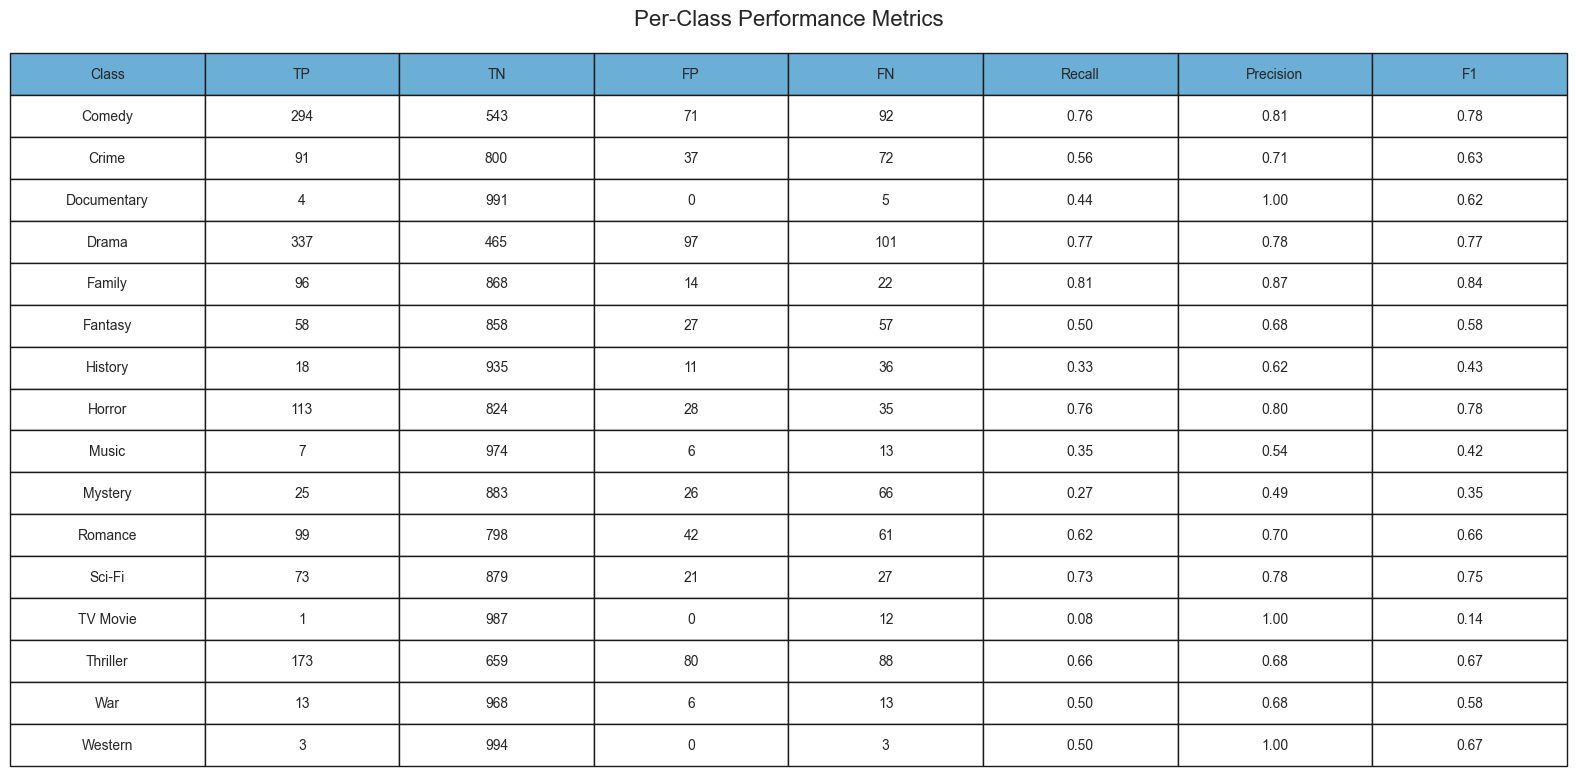

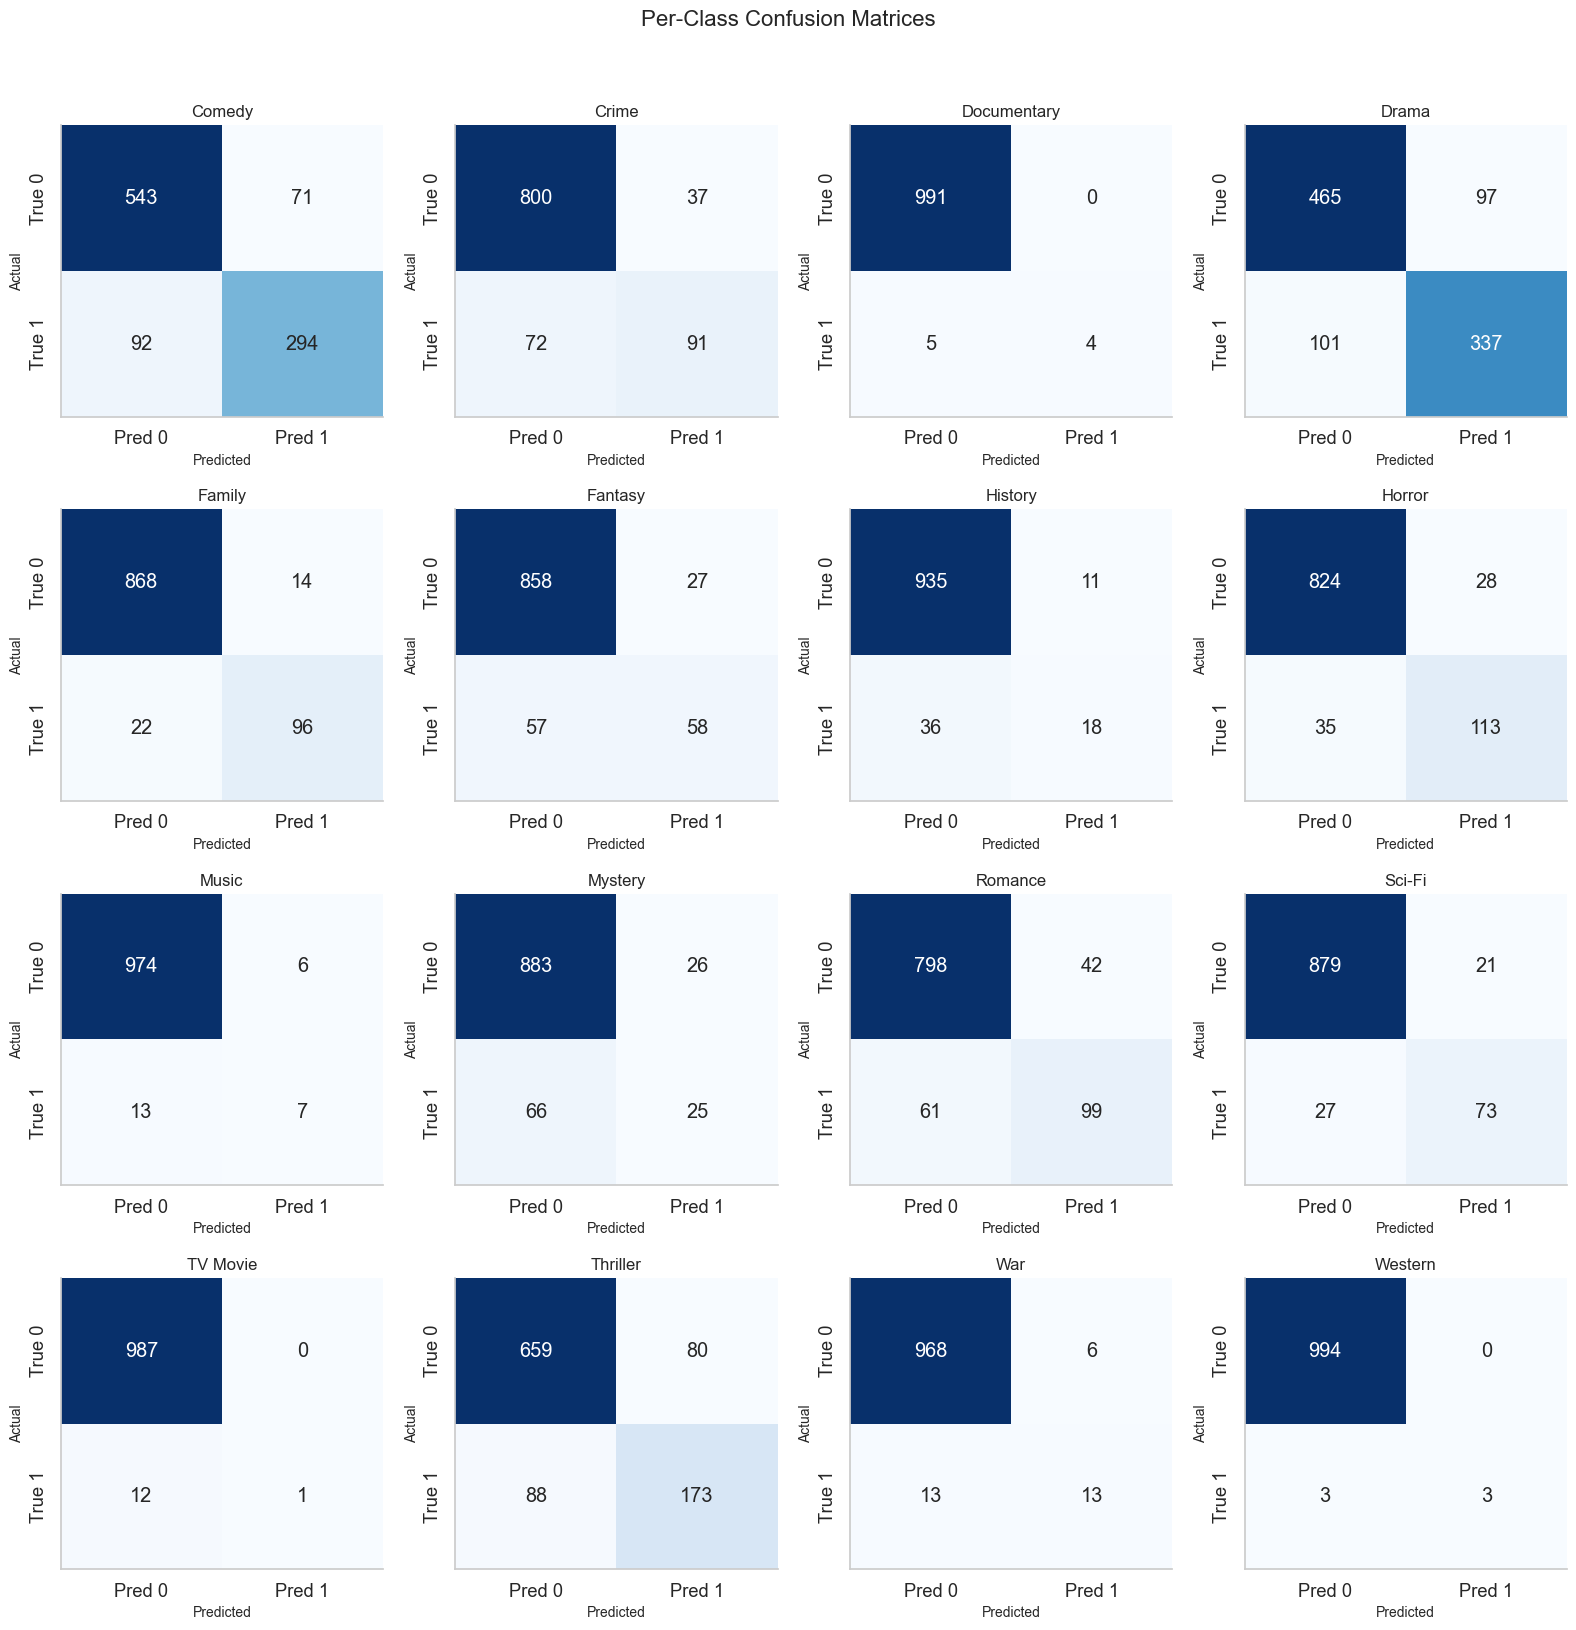

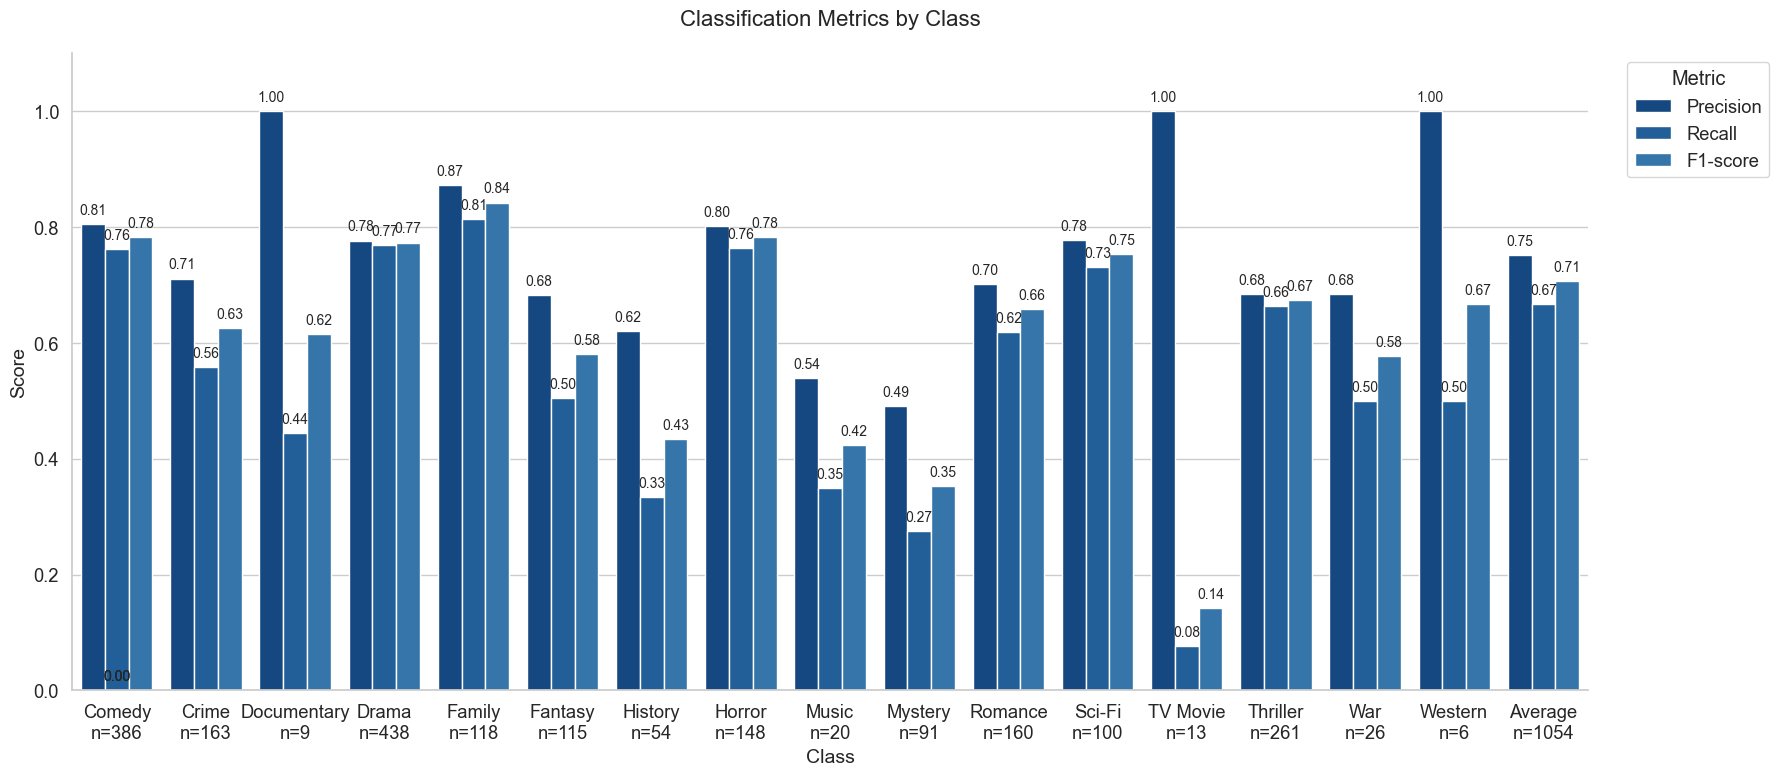


Detailed Classification Report:
              precision    recall  f1-score   support

      Comedy      0.805     0.762     0.783       386
       Crime      0.711     0.558     0.625       163
 Documentary      1.000     0.444     0.615         9
       Drama      0.776     0.769     0.773       438
      Family      0.873     0.814     0.842       118
     Fantasy      0.682     0.504     0.580       115
     History      0.621     0.333     0.434        54
      Horror      0.801     0.764     0.782       148
       Music      0.538     0.350     0.424        20
     Mystery      0.490     0.275     0.352        91
     Romance      0.702     0.619     0.658       160
      Sci-Fi      0.777     0.730     0.753       100
    TV Movie      1.000     0.077     0.143        13
    Thriller      0.684     0.663     0.673       261
         War      0.684     0.500     0.578        26
     Western      1.000     0.500     0.667         6

   micro avg      0.751     0.667     0.706    

In [ ]:
class_names = ['Comedy', 'Crime', 'Documentary',
                'Drama', 'Family', 'Fantasy', 'History',
                'Horror', 'Music', 'Mystery', 'Romance',
                'Sci-Fi', 'TV Movie', 'Thriller',
                'War', 'Western']

evaluate_model(multi_xgb, X_test_dnn, y_test, class_names)

In [ ]:
feature_extractor.save('best_model/all_data/dnn_feature_extractor.h5')
joblib.dump(multi_xgb, 'best_model/all_data/multi_xgb_classifier.pkl')

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


['best_models/all_data/multi_xgb_classifier.pkl']

### 2. More than 10 example data

In [255]:
best_dnn_params = {
    "dnn_layers": [1024, 512, 256],
    "dropout_rate": 0.4,
    "learning_rate": 5e-5,
    "batch_size": 128,
    "epochs": 80,
    "optimizer": "adam"
}

best_xgb_params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "n_estimators": 200,
    "subsample": 0.8,
    "objective": 'binary:logistic',
    "eval_metric": 'logloss',
    "use_label_encoder": False,
    "verbosity": 0
}

def build_feature_extractor(input_shape, params):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for units in params["dnn_layers"]:
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(params["dropout_rate"])(x)
    
    feature_output = x
    output_layer = Dense(y_train.shape[1], activation='sigmoid')(feature_output)

    optimizer = Adam(learning_rate=params["learning_rate"])
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model, feature_output

dnn_model, feature_output = build_feature_extractor((X_train.shape[1],), best_dnn_params)

print("Training DNN feature extractor...")
history = dnn_model.fit(
    X_train, y_train,
    epochs=best_dnn_params["epochs"],
    batch_size=best_dnn_params["batch_size"],
    validation_data=(X_val, y_val),
    verbose=1
)

feature_extractor = Model(inputs=dnn_model.input, outputs=feature_output)

print("Extracting features...")
X_train_dnn = feature_extractor.predict(X_train)
X_test_dnn_2 = feature_extractor.predict(X_test)

print("Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(**best_xgb_params)
multi_xgb_2 = MultiOutputClassifier(xgb_model)
multi_xgb_2.fit(X_train_dnn, y_train)

Training DNN feature extractor...
Epoch 1/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0703 - loss: 0.9733 - val_accuracy: 0.2707 - val_loss: 0.6769
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1232 - loss: 0.9114 - val_accuracy: 0.2980 - val_loss: 0.6695
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1601 - loss: 0.8709 - val_accuracy: 0.3046 - val_loss: 0.6577
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1848 - loss: 0.8465 - val_accuracy: 0.3373 - val_loss: 0.6467
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2044 - loss: 0.8221 - val_accuracy: 0.3788 - val_loss: 0.6337
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2270 - loss: 0.8004 - val_accuracy: 0.4170 - val_loss: 0.6188
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2600 - loss: 0.7805 - val_accuracy: 0.4345 - val_loss: 0.6049
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2599 - loss:

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=8,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...))

In [ ]:
feature_extractor.save('best_model/more_than_10_example/dnn_feature_extractor.h5')
joblib.dump(multi_xgb_2, 'best_model/more_than_10_example/multi_xgb_classifier.pkl')

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


['best_models/more_than_10_example/multi_xgb_classifier.pkl']

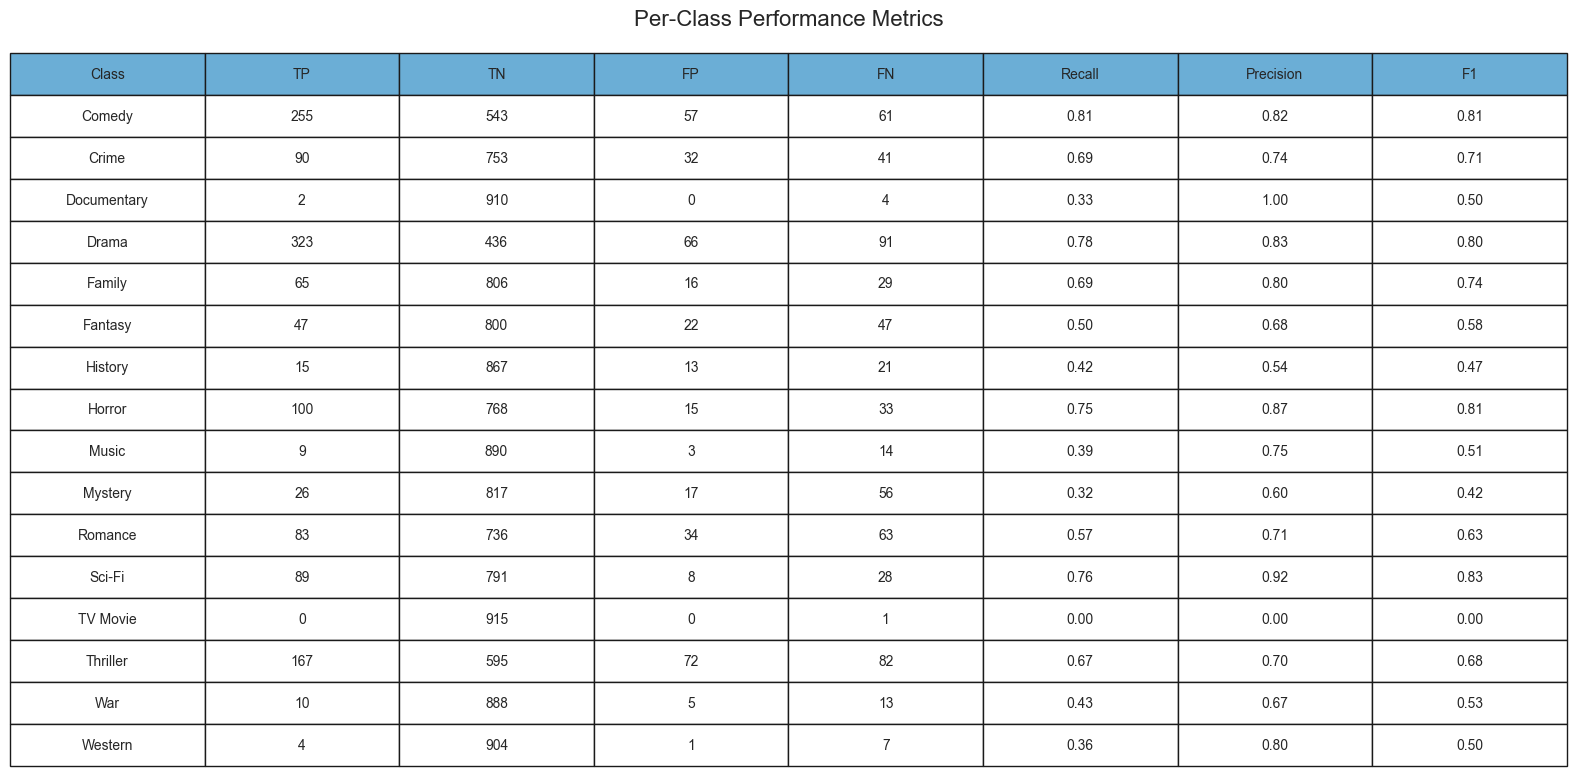

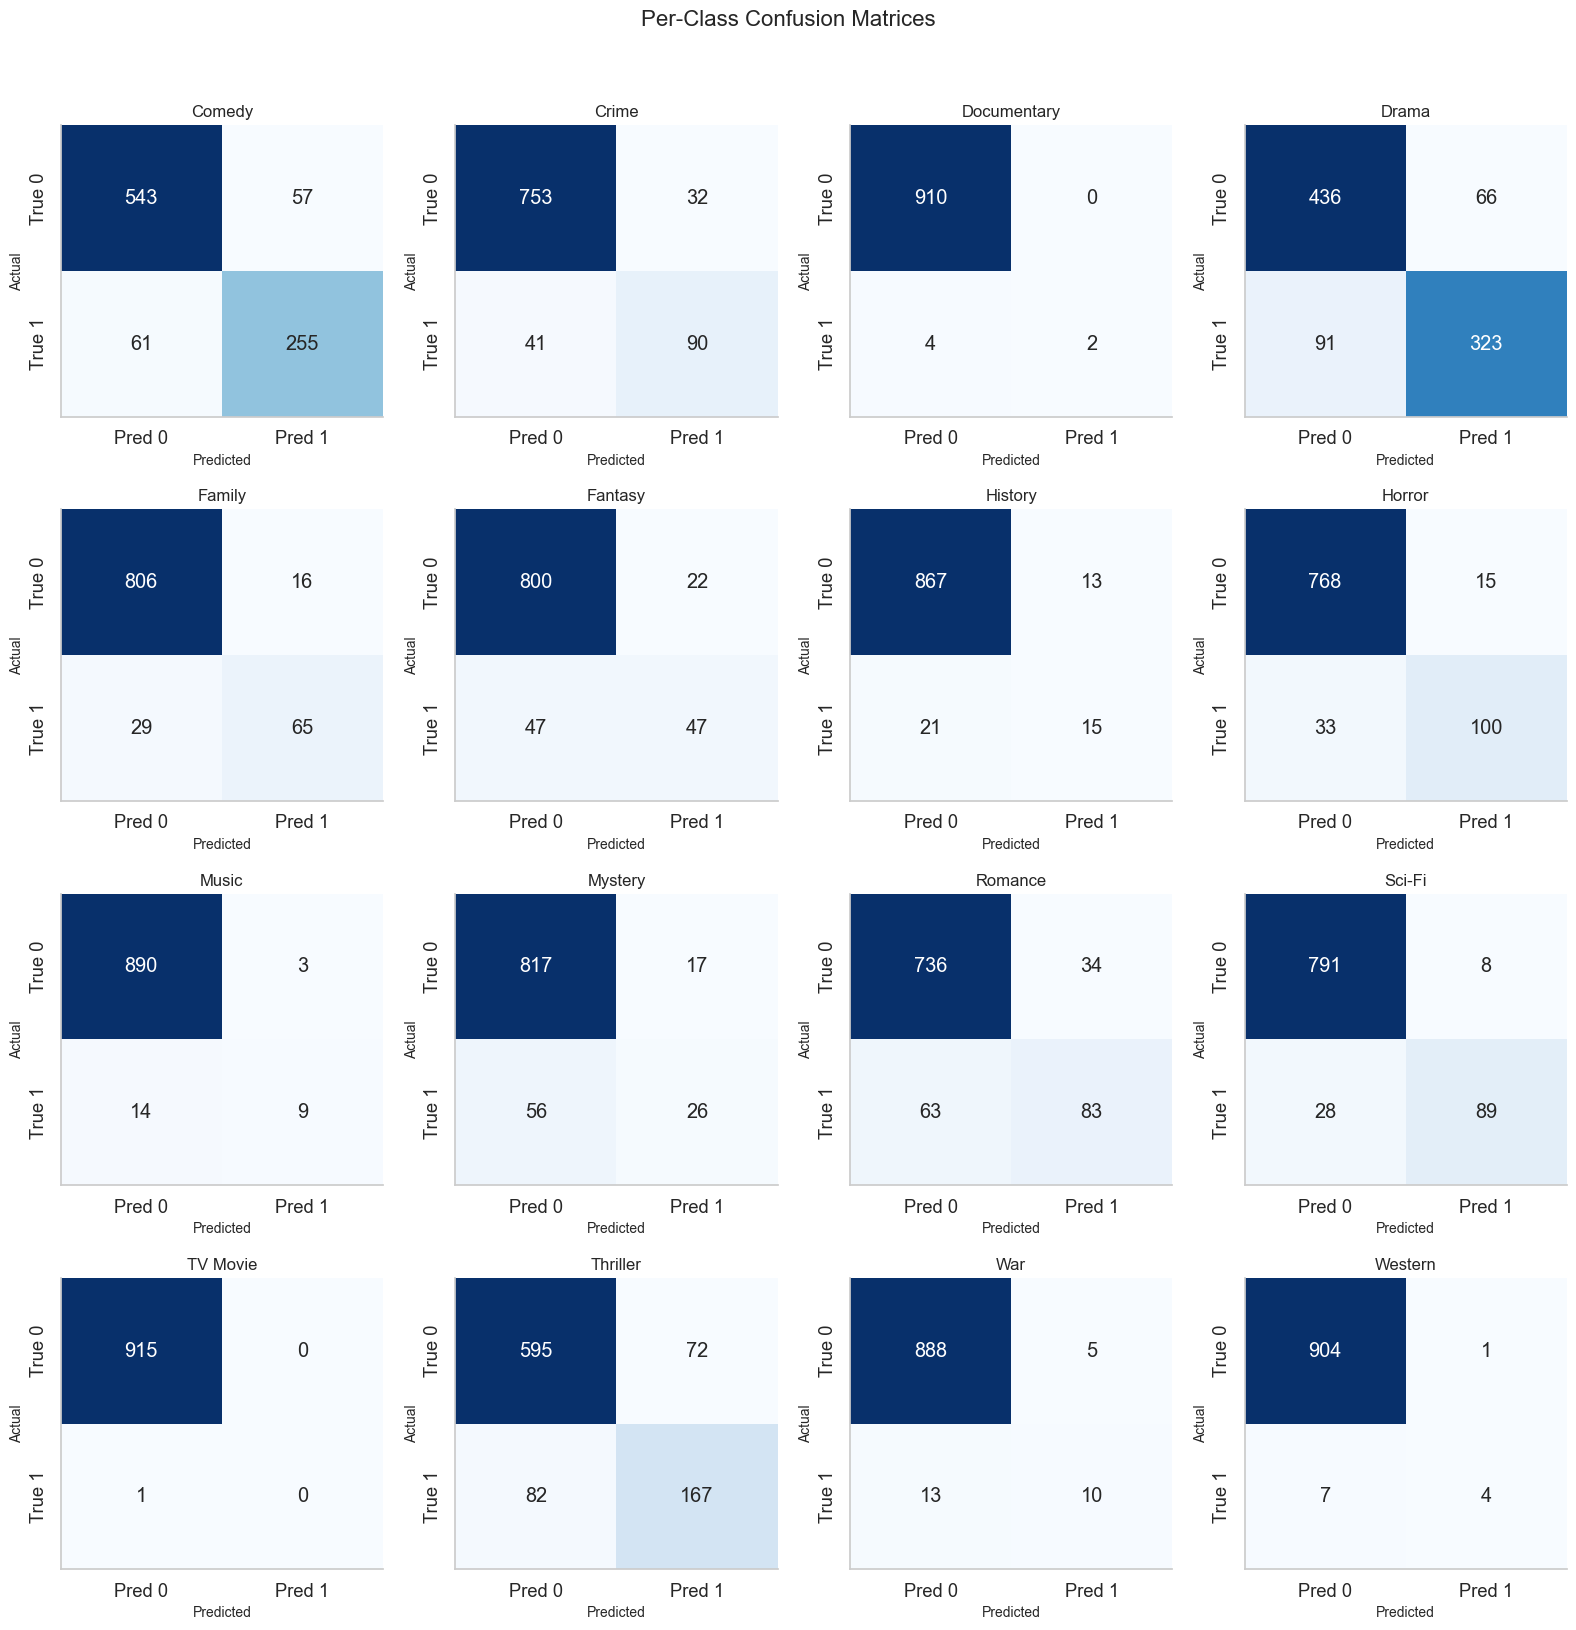

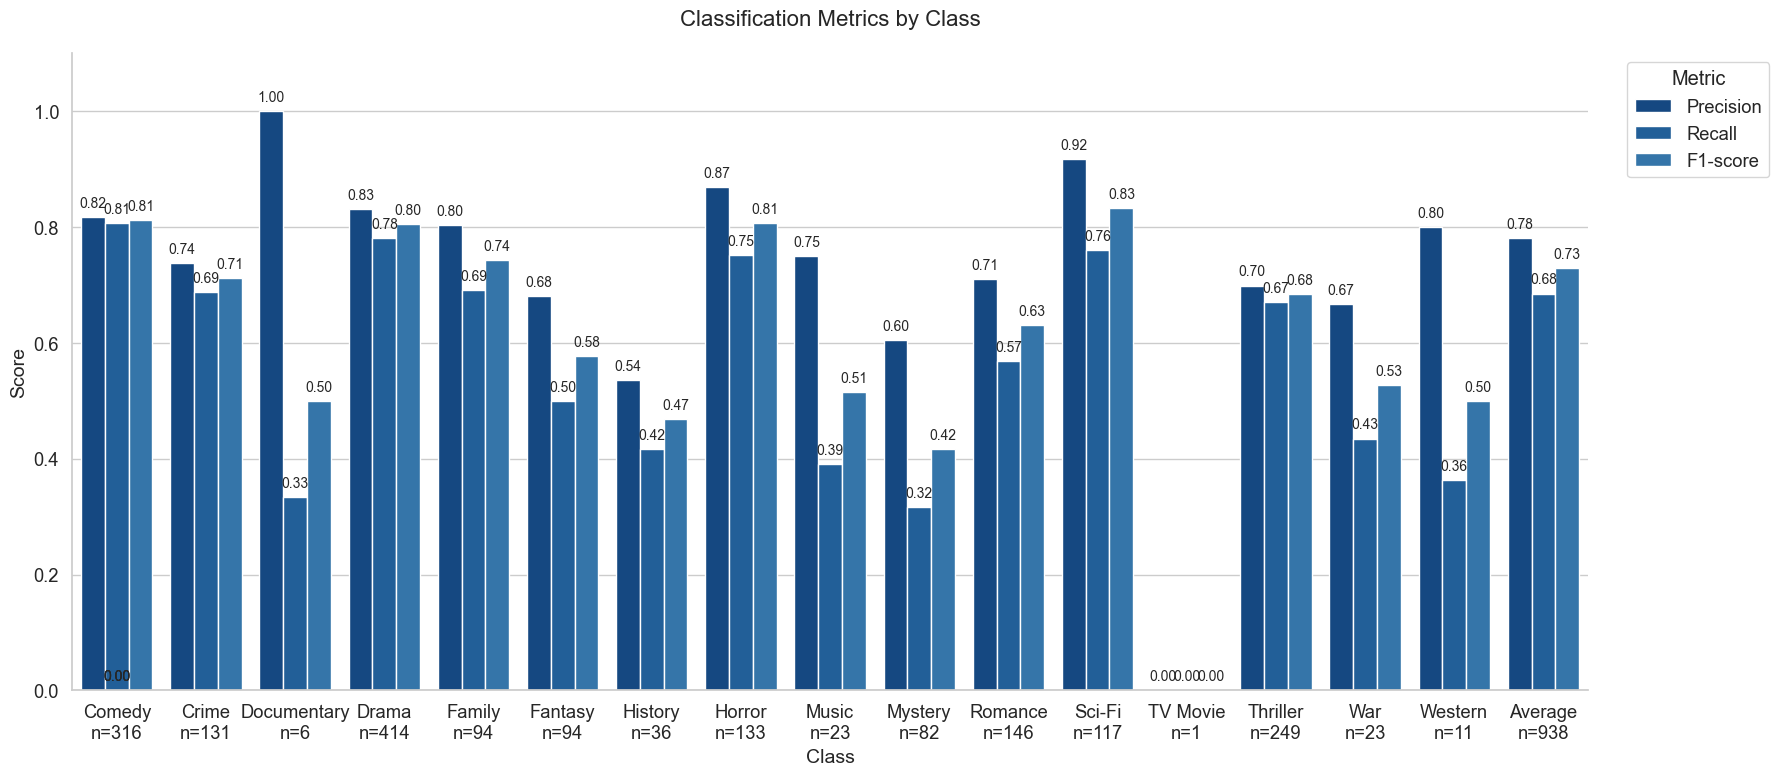


Detailed Classification Report:
              precision    recall  f1-score   support

      Comedy      0.817     0.807     0.812       316
       Crime      0.738     0.687     0.711       131
 Documentary      1.000     0.333     0.500         6
       Drama      0.830     0.780     0.804       414
      Family      0.802     0.691     0.743        94
     Fantasy      0.681     0.500     0.577        94
     History      0.536     0.417     0.469        36
      Horror      0.870     0.752     0.806       133
       Music      0.750     0.391     0.514        23
     Mystery      0.605     0.317     0.416        82
     Romance      0.709     0.568     0.631       146
      Sci-Fi      0.918     0.761     0.832       117
    TV Movie      0.000     0.000     0.000         1
    Thriller      0.699     0.671     0.684       249
         War      0.667     0.435     0.526        23
     Western      0.800     0.364     0.500        11

   micro avg      0.781     0.685     0.730    

In [ ]:
evaluate_model(multi_xgb_2, X_test_dnn_2, y_test, class_names)

## Model Performance Comparison

In [ ]:
def compare_model_f1_scores(y_true_all, y_pred_all, 
                          y_true_more10, y_pred_more10, 
                          class_names):
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(20, 8))
    
    report_all = classification_report(y_true_all, y_pred_all, 
                                     target_names=class_names, 
                                     output_dict=True)
    report_more10 = classification_report(y_true_more10, y_pred_more10, 
                                        target_names=class_names, 
                                        output_dict=True)

    f1_scores = []
    for cls in class_names + ['Average']:
        if cls == 'Average':
            score_all = report_all['micro avg']['f1-score']
            score_more10 = report_more10['micro avg']['f1-score']
            support = int(report_all['micro avg']['support']/2)
        else:
            score_all = report_all[cls]['f1-score']
            score_more10 = report_more10[cls]['f1-score']
            support = int(report_all[cls]['support'])
        
        f1_scores.append({
            'Class': cls,
            'F1-score': score_all,
            'Model': 'all_data',
            'Support': support
        })
        f1_scores.append({
            'Class': cls,
            'F1-score': score_more10,
            'Model': 'more_10_exp',
            'Support': support
        })
    
    df = pd.DataFrame(f1_scores)

    ax = sns.barplot(x='Class', y='F1-score', hue='Model', data=df,
                    palette=['#1f77b4', '#ff7f0e'], 
                    saturation=0.8)
    
    sns.despine()

    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f"{height:.2f}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center',
                       xytext=(0, 10),
                       textcoords='offset points',
                       fontsize=10)
    
    ax.set_title('F1-score Comparison: all_data vs more_10_exp', 
                fontsize=16, pad=20)
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('F1-score', fontsize=14)
    ax.set_ylim(0, 1.1)

    unique_classes = df['Class'].unique()
    supports = [df[df['Class'] == cls]['Support'].iloc[0] for cls in unique_classes]
    ax.set_xticklabels([f"{cls}\nn={supp}" for cls, supp in zip(unique_classes, supports)])
    
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report for all_data:")
    print(classification_report(y_true_all, y_pred_all, 
                              target_names=class_names, digits=3))
    
    print("\nClassification Report for more_10_exp:")
    print(classification_report(y_true_more10, y_pred_more10, 
                              target_names=class_names, digits=3))

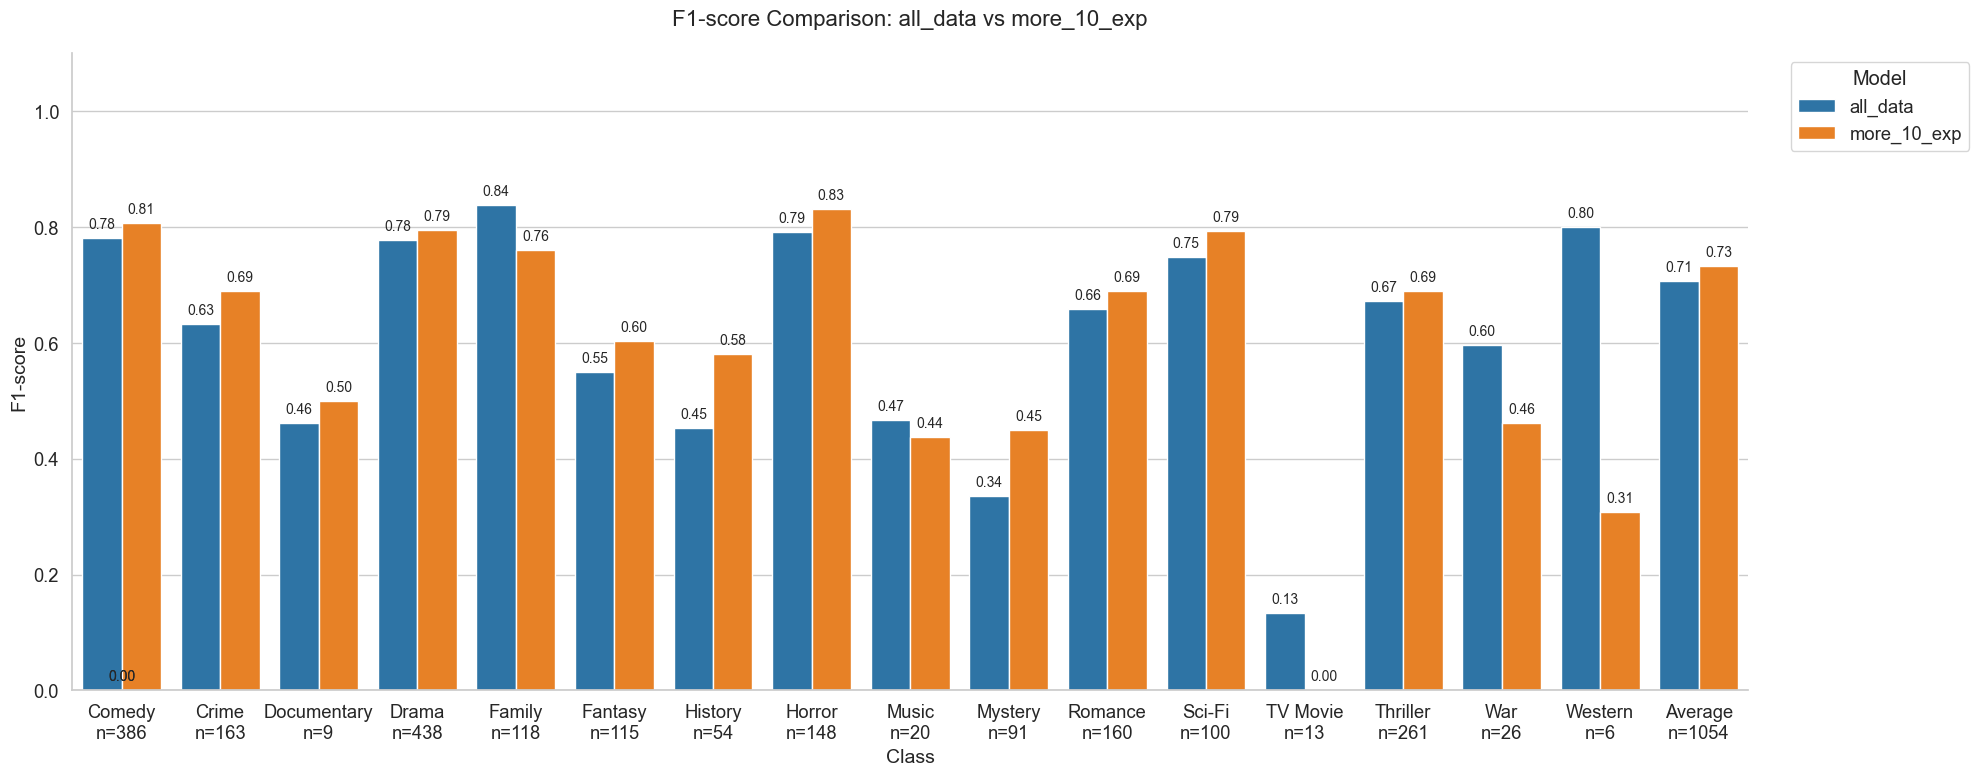


Classification Report for all_data:
              precision    recall  f1-score   support

      Comedy      0.807     0.756     0.781       386
       Crime      0.719     0.564     0.632       163
 Documentary      0.750     0.333     0.462         9
       Drama      0.774     0.781     0.777       438
      Family      0.865     0.814     0.838       118
     Fantasy      0.703     0.452     0.550       115
     History      0.633     0.352     0.452        54
      Horror      0.804     0.777     0.790       148
       Music      0.700     0.350     0.467        20
     Mystery      0.462     0.264     0.336        91
     Romance      0.727     0.600     0.658       160
      Sci-Fi      0.726     0.770     0.748       100
    TV Movie      0.500     0.077     0.133        13
    Thriller      0.694     0.651     0.672       261
         War      0.667     0.538     0.596        26
     Western      1.000     0.667     0.800         6

   micro avg      0.752     0.666     0.707

In [294]:
y_pred_probsall = multi_xgb.predict(X_test_dnn)
y_pred_all = (y_pred_probsall > 0.5).astype(int)

y_pred_probs_more10 = multi_xgb_2.predict(X_test_dnn_2)
y_pred_more10 = (y_pred_probs_more10 > 0.5).astype(int)

compare_model_f1_scores(y_test_all, y_pred_all, 
                       y_test_more10, y_pred_more10, 
                       class_names=class_names)